In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# Radar Cross Section (RCS) of a 5m × 5m Flat Plate

## Introduction

This notebook demonstrates RCS analysis of a **flat plate**—one of the fundamental canonical shapes in radar scattering theory. Flat plates represent the simplest scattering geometry and serve as building blocks for understanding more complex targets.

### Flat Plate as a Canonical Scatterer

A **flat conducting plate** is a fundamental reference object in electromagnetic scattering with well-known analytical solutions. Understanding plate RCS is essential for:

- **Validating simulation tools** against closed-form solutions
- **Understanding basic scattering mechanisms** (specular reflection)
- **Approximating faceted objects** (ships, aircraft panels, buildings)
- **Design baseline comparisons** for stealth and RCS reduction

### Theoretical RCS of a Flat Plate

For a rectangular flat plate with dimensions $L_x × L_y$, the **monostatic RCS** at normal incidence (broadside) is:

$$\sigma_{max} = \frac{4\pi L_x^2 L_y^2}{\lambda^2}$$

Where:
- $\sigma_{max}$ = Maximum RCS (m²)
- $L_x, L_y$ = Plate dimensions (m)
- $\lambda$ = Radar wavelength (m)

**For a 5m × 5m plate at 1 GHz:**
- Wavelength: λ = 0.3 m
- Theoretical RCS: σ = 4π(25)²/(0.09) ≈ **34,907 m²** or **45.4 dBsm**

**Angular Dependence:**

The RCS drops off rapidly with angle θ from broadside:

$$\sigma(\theta) \approx \sigma_{max} \cdot \text{sinc}^2\left(\frac{2\pi L \sin\theta}{\lambda}\right)$$

This creates a narrow main lobe with nulls at specific angles determined by plate size.

### Monostatic vs. Bistatic RCS

**Monostatic Configuration:**
- Transmitter and receiver at same location
- Incident angle = Observation angle
- Maximum RCS at normal incidence (specular reflection)
- Most common radar configuration

**Bistatic Configuration:**
- Transmitter and receiver at different locations
- Incident angle ≠ Observation angle
- Peak RCS when specular reflection condition is met
- Used in passive radar and special applications

**Specular Reflection Condition:**

Maximum RCS occurs when the angle of reflection equals the angle of incidence (mirror-like reflection), similar to optical reflection.

### Material Properties and RCS

**Perfect Electric Conductor (PEC):**
- Complete reflection of electromagnetic waves
- Maximum possible RCS for a given geometry
- Models metal objects (aluminum, steel, copper)
- Zero transmission through the surface

**Dielectric Materials:**
- Partial reflection and partial transmission
- RCS reduced compared to PEC
- Depends on complex permittivity: ε = ε' - jε''
- Examples: glass, plastics, composites, radomes

**Reflection Coefficient:**

For a dielectric interface, the reflection coefficient depends on permittivity and incident angle, following Fresnel equations. Higher permittivity → stronger reflection → higher RCS.

### You'll Learn How To:

- Load and visualize flat plate 3D models
- Simulate monostatic RCS with different material properties (PEC vs. dielectric)
- Compare conductor and glass plate radar signatures
- Configure bistatic RCS simulations with separate incident/observation angles
- Analyze polarization effects in bistatic geometry (V-pol vs. H-pol)
- Understand specular reflection and its angular characteristics
- Validate simulation results against theoretical predictions
- Apply material property modeling in RCS calculations

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to simulate a 5m × 5m flat plate's RCS in two configurations:

1. **Monostatic RCS**: Comparing perfect conductor (PEC) vs. glass (εᵣ = 5)
2. **Bistatic RCS**: Analyzing vertical and horizontal polarization responses

We'll observe how material properties and geometry affect radar signatures, providing insights into fundamental scattering mechanisms.

## 3D Model Loading

Load the flat plate geometry using PyMeshLab. The model represents a 5m × 5m square plate in the XY plane.

### Model Configuration

Define the path to the flat plate 3D model file.

In [2]:
# Import necessary libraries for mesh processing and numerical operations
import pymeshlab
import numpy as np

# Path to 5m x 5m flat plate model
model_path = "../models/plate5x5.stl"

### Visualize 3D Model

Display the flat plate geometry to verify dimensions and orientation. The plate lies in the XY plane, making it ideal for studying angular RCS variations.

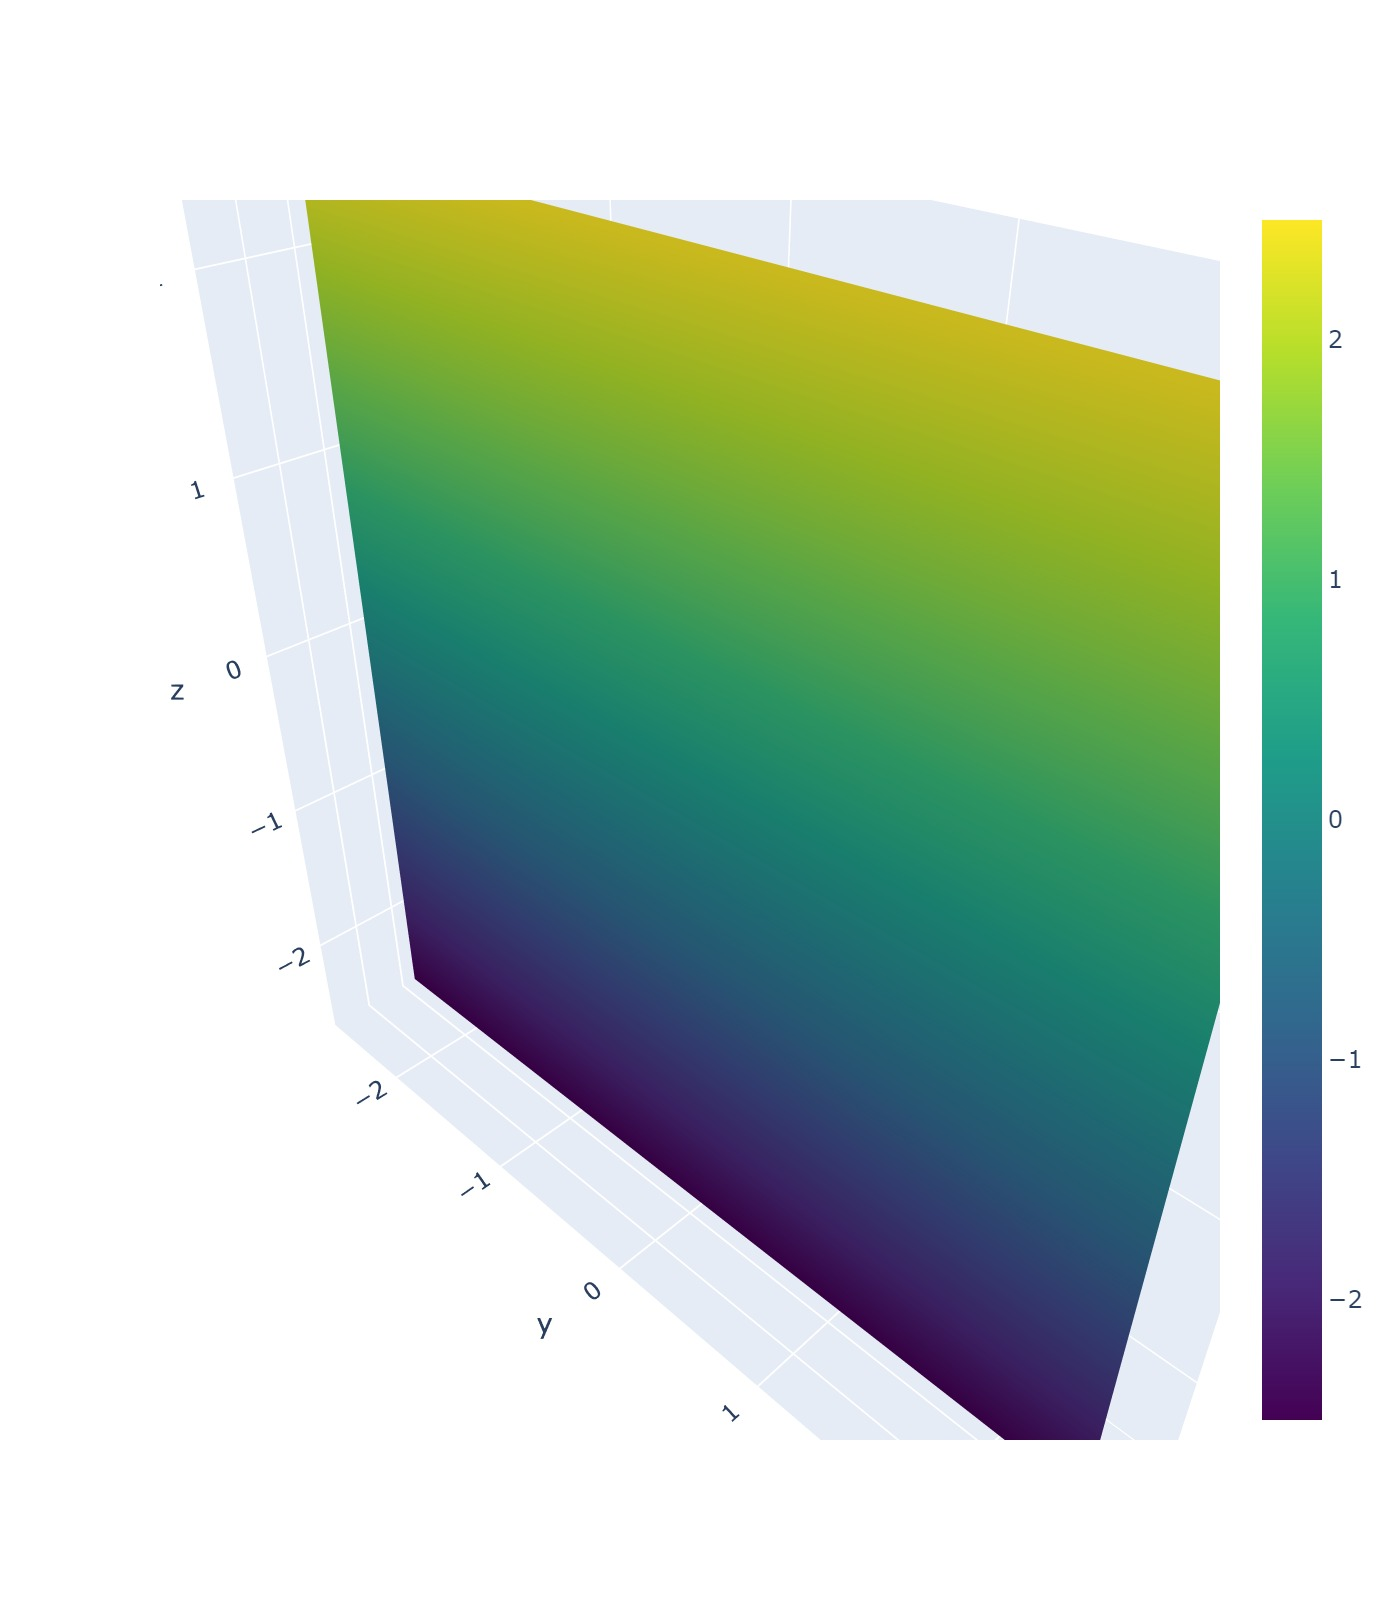

In [3]:
# Import plotting libraries
import plotly.graph_objs as go
from IPython.display import Image

# Load 3D mesh using PyMeshLab
ms = pymeshlab.MeshSet()
ms.load_new_mesh(model_path)
t_mesh = ms.current_mesh()

# Extract vertex positions and face connectivity
v_matrix = np.array(t_mesh.vertex_matrix())  # Vertex coordinates (N x 3)
f_matrix = np.array(t_mesh.face_matrix())    # Face indices (M x 3)

# Create 3D mesh visualization
fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],        # X coordinates
        y=v_matrix[:, 1],        # Y coordinates
        z=v_matrix[:, 2],        # Z coordinates
        i=f_matrix[:, 0],        # Face vertex indices
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],  # Color by height
        colorscale="Viridis",      # Color scheme
    )
)

# Configure 3D plot layout
fig["layout"]["scene"]["aspectmode"] = "data"  # Maintain aspect ratio
fig["layout"]["height"] = 800                   # Plot height in pixels

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Monostatic RCS Simulation

In monostatic configuration, the incident and observation angles are identical—simulating a typical radar where the transmitter and receiver are co-located.

### Configuration Parameters

**Observation Geometry:**
- **Azimuth (φ)**: -90° to +90° in 0.5° steps (180° angular sweep)
- **Elevation (θ)**: Fixed at 90° (horizontal plane)
- **Monostatic**: Radar and target in same relative position

**Radar Parameters:**
- **Frequency**: 1 GHz (L-band)
- **Wavelength**: λ = 0.3 m
- **Polarization**: Vertical [0, 0, 1]
- **Ray Density**: 4 rays per λ²

**Material Configurations:**

1. **Perfect Electric Conductor (PEC)**
   - Represents ideal metal (100% reflection)
   - Maximum possible RCS for this geometry
   - No transmission through material

2. **Glass Plate**
   - Relative permittivity: εᵣ = 5
   - Partial reflection (~30-40% at normal incidence)
   - Reduced RCS compared to PEC

**Expected Results:**
- **Peak RCS**: At 0° (broadside, normal incidence)
- **Nulls**: At angles where path difference causes destructive interference
- **PEC > Glass**: Metal reflects more strongly than dielectric
- **Narrow Beamwidth**: Large plate (5m >> λ) creates sharp pattern

### Run Monostatic Simulation

Compute RCS for both PEC and glass materials across all angles.

In [4]:
# Import time module for performance measurement
import time

# Import RCS simulation function
from radarsimpy.simulator import sim_rcs

# Define observation angles for monostatic configuration
phi = np.arange(-90, 90, 0.5)    # Azimuth: -90° to +90° in 0.5° steps
theta = np.zeros_like(phi) + 90   # Elevation: fixed at 90° (horizontal)

# Radar parameters
freq = 1e9         # Frequency: 1 GHz (L-band)
pol = [0, 0, 1]    # Vertical polarization
density = 4        # Ray density: 4 rays per wavelength²

# Target configuration 1: Perfect Electric Conductor (PEC)
target_pec = {
    "model": model_path,
    "unit": "m",
    "location": (0, 0, 0),
    # No permittivity specified → defaults to PEC
}

# Target configuration 2: Glass plate with dielectric properties
target_glass = {
    "model": model_path,
    "unit": "m",
    "location": (0, 0, 0),
    "permittivity": 5,  # Relative permittivity εᵣ = 5 (typical glass)
}

# Start timing
tic = time.time()

# Simulate RCS for PEC plate
# Add small constant (1e-6) to avoid log10(0) for nulls
rcs_pec = 10 * np.log10(
    sim_rcs([target_pec], freq, phi, theta, pol, density=density) + 0.000001
)

# Simulate RCS for glass plate
rcs_glass = 10 * np.log10(
    sim_rcs([target_glass], freq, phi, theta, pol, density=density) + 0.000001
)

# End timing
toc = time.time()

# Display execution time
print("Exec time: " + str(toc - tic) + " s")

Exec time: 1.5885944366455078 s


### Visualize Monostatic RCS Pattern

Compare the RCS patterns of PEC and glass plates to observe the effect of material properties.

**Key Features to Observe:**

1. **Peak RCS at 0°**: Both materials show maximum return at broadside (normal incidence)
2. **RCS Magnitude**: PEC produces significantly higher RCS than glass
3. **Main Lobe Width**: Narrow beamwidth (~3-4°) due to large electrical size (5m/0.3m ≈ 17λ)
4. **Side Lobes**: Multiple nulls and secondary peaks due to edge diffraction
5. **Material Effect**: Glass shows ~10-15 dB reduction compared to PEC

**Physical Interpretation:**
- Large plate creates highly directional pattern
- Interference patterns from edges create nulls
- Dielectric reduces reflection coefficient, lowering overall RCS

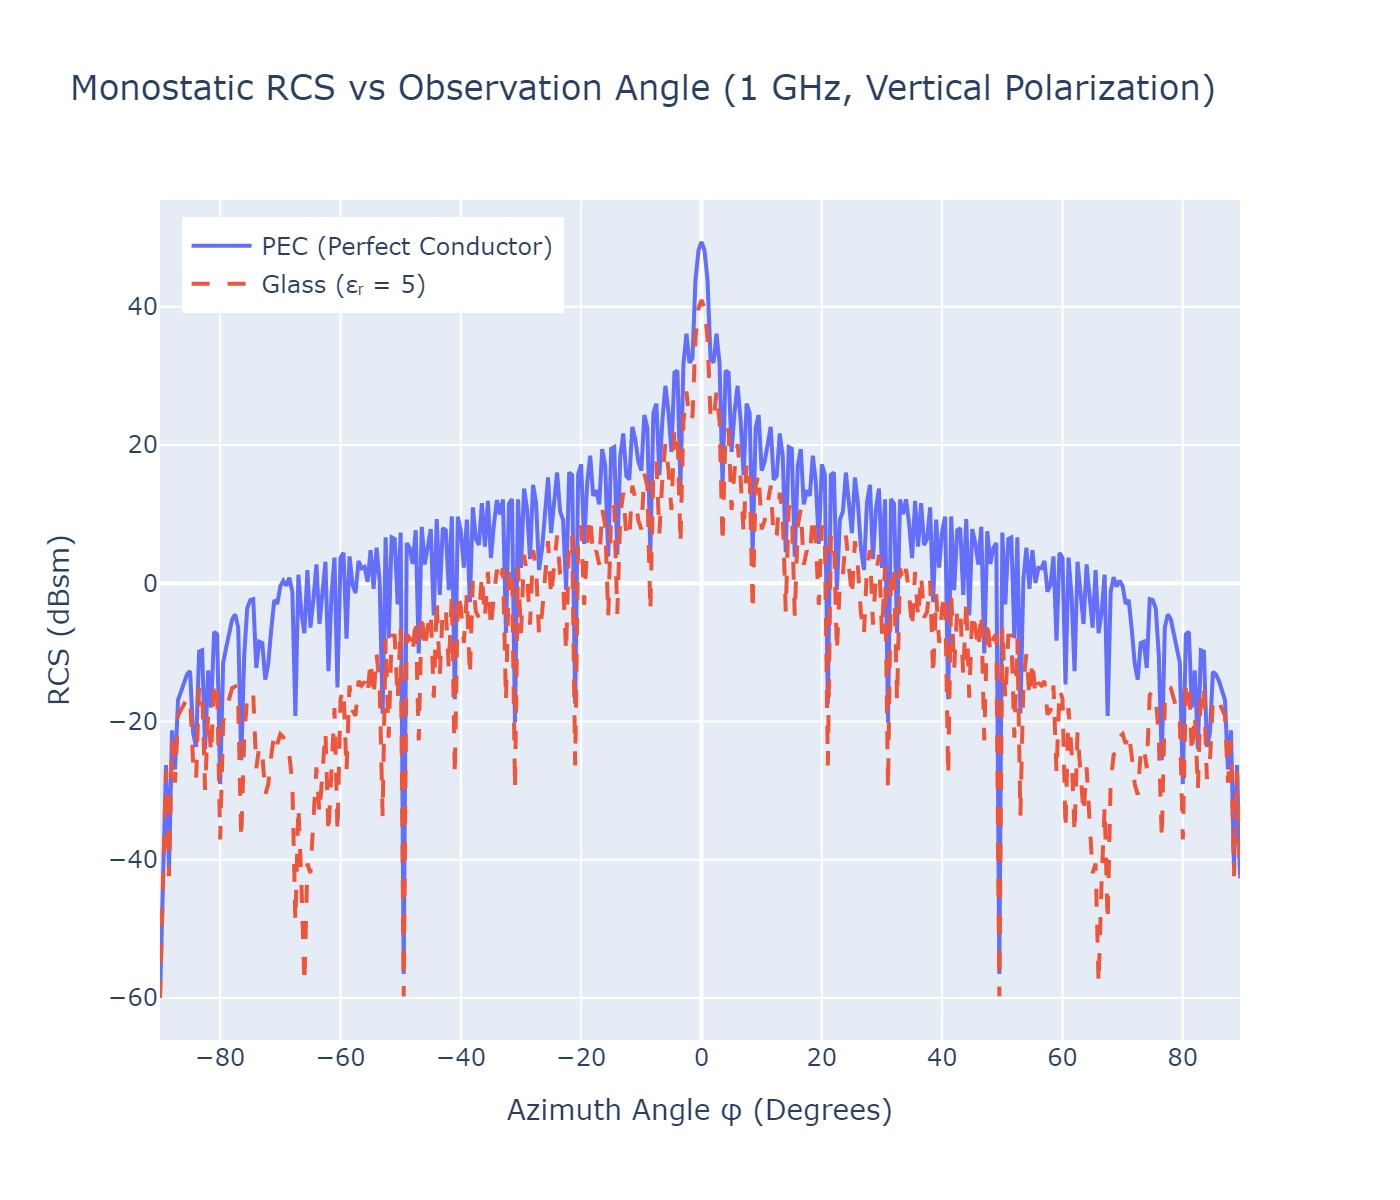

In [5]:
# Create figure for monostatic RCS comparison
fig = go.Figure()

# Plot PEC RCS pattern
fig.add_trace(go.Scatter(
    x=phi,
    y=rcs_pec,
    mode='lines',
    name="PEC (Perfect Conductor)",
    line=dict(width=2)
))

# Plot Glass RCS pattern
fig.add_trace(go.Scatter(
    x=phi,
    y=rcs_glass,
    mode='lines',
    name="Glass (εᵣ = 5)",
    line=dict(width=2, dash='dash')
))

# Configure plot layout
fig.update_layout(
    title="Monostatic RCS vs Observation Angle (1 GHz, Vertical Polarization)",
    yaxis=dict(title="RCS (dBsm)"),
    xaxis=dict(title="Azimuth Angle φ (Degrees)", dtick=20),
    height=600,
    legend=dict(x=0.02, y=0.98),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Bistatic RCS Simulation

In bistatic configuration, the incident and observation angles are different—simulating scenarios where transmitter and receiver are at separate locations.

### Configuration Parameters

**Incident Wave:**
- **Incident Azimuth**: 45° (fixed illumination angle)
- **Incident Elevation**: 90° (horizontal plane)
- **Two Polarizations**: Vertical and Horizontal

**Observation Geometry:**
- **Observation Azimuth**: -90° to +90° sweep
- **Observation Elevation**: 90° (horizontal plane)
- **Bistatic angle**: Varies from 135° to 45° as observer moves

**Radar Parameters:**
- **Frequency**: 1 GHz (L-band)
- **Ray Density**: 1 ray per λ² (faster computation)
- **Material**: PEC only for this analysis

**Polarization Configurations:**

1. **Vertical Polarization (V-pol)**: [0, 0, 1]
   - Electric field perpendicular to ground plane
   - Typical for ground-based radars

2. **Horizontal Polarization (H-pol)**: [0, 1, 0]
   - Electric field parallel to ground plane
   - Different scattering characteristics

**Expected Results:**
- **Specular Peak**: Maximum RCS when observation angle = -45° (mirror reflection)
- **Polarization Difference**: V-pol and H-pol show different patterns
- **Asymmetric Pattern**: Unlike monostatic, not symmetric about 0°
- **Lower Peak**: Bistatic RCS typically lower than monostatic at same angles

**Specular Condition:**
For incident angle of 45°, specular reflection occurs at observation angle of -45° (equal angle on opposite side of surface normal).

### Run Bistatic Simulation

Compute RCS for both polarizations across all observation angles. Loop through each angle to compute bistatic RCS.

In [6]:
# Define observation angles for bistatic configuration
obs_phi = np.arange(-90, 90, 0.5)  # Observation azimuth sweep
obs_theta = 90                      # Observation elevation (horizontal)

# Radar parameters
freq = 1e9       # Frequency: 1 GHz
pol = [0, 1, 0]  # Will be overridden in sim_rcs calls
density = 1      # Ray density: 1 ray per λ² (faster for bistatic)

# Initialize RCS arrays for two polarizations
rcs_vpol = np.zeros_like(obs_phi)  # Vertical polarization results
rcs_hpol = np.zeros_like(obs_phi)  # Horizontal polarization results

# Fixed incident wave direction
inc_phi = 45     # Incident azimuth: 45° (illumination from side)
inc_theta = 90   # Incident elevation: 90° (horizontal)

# Target configuration (PEC only)
target_pec = {
    "model": model_path,
    "location": (0, 0, 0),
}

# Start timing
tic = time.time()

# Loop through each observation angle
for phi_idx, phi_ang in enumerate(obs_phi):
    # Simulate bistatic RCS with vertical incident polarization
    rcs_vpol[phi_idx] = 10 * np.log10(
        sim_rcs(
            [target_pec],
            freq,
            inc_phi=inc_phi,           # Incident azimuth
            inc_theta=inc_theta,       # Incident elevation
            inc_pol=[0, 0, 1],         # Vertical polarization
            obs_phi=phi_ang,           # Observation azimuth (varies)
            obs_theta=obs_theta,       # Observation elevation
            density=density,
        )
        + 0.0000001  # Avoid log10(0)
    )
    
    # Simulate bistatic RCS with horizontal incident polarization
    rcs_hpol[phi_idx] = 10 * np.log10(
        sim_rcs(
            [target_pec],
            freq,
            inc_phi=inc_phi,
            inc_theta=inc_theta,
            inc_pol=[0, 1, 0],         # Horizontal polarization
            obs_phi=phi_ang,
            obs_theta=obs_theta,
            density=density,
        )
        + 0.0000001
    )

# End timing
toc = time.time()

# Display execution time
print("Exec time: " + str(toc - tic) + " s")

Exec time: 1.4725048542022705 s


### Visualize Bistatic RCS Pattern

Compare vertical and horizontal polarization responses in bistatic geometry.

**Key Features to Observe:**

1. **Specular Peak**: Maximum RCS near -45° observation angle (mirror reflection of 45° incident)
2. **Polarization Dependence**: V-pol and H-pol show different scattering patterns
3. **Asymmetric Pattern**: Not symmetric about 0° (unlike monostatic)
4. **Scattering Lobes**: Multiple peaks due to edge diffraction and interference
5. **Null Locations**: Deep nulls where destructive interference occurs

**Physical Interpretation:**
- Specular reflection dominates when observation angle mirrors incident angle
- Polarization affects reflection coefficients at non-normal incidence
- Bistatic geometry reveals different aspects of target scattering properties
- Edge effects create complex interference patterns

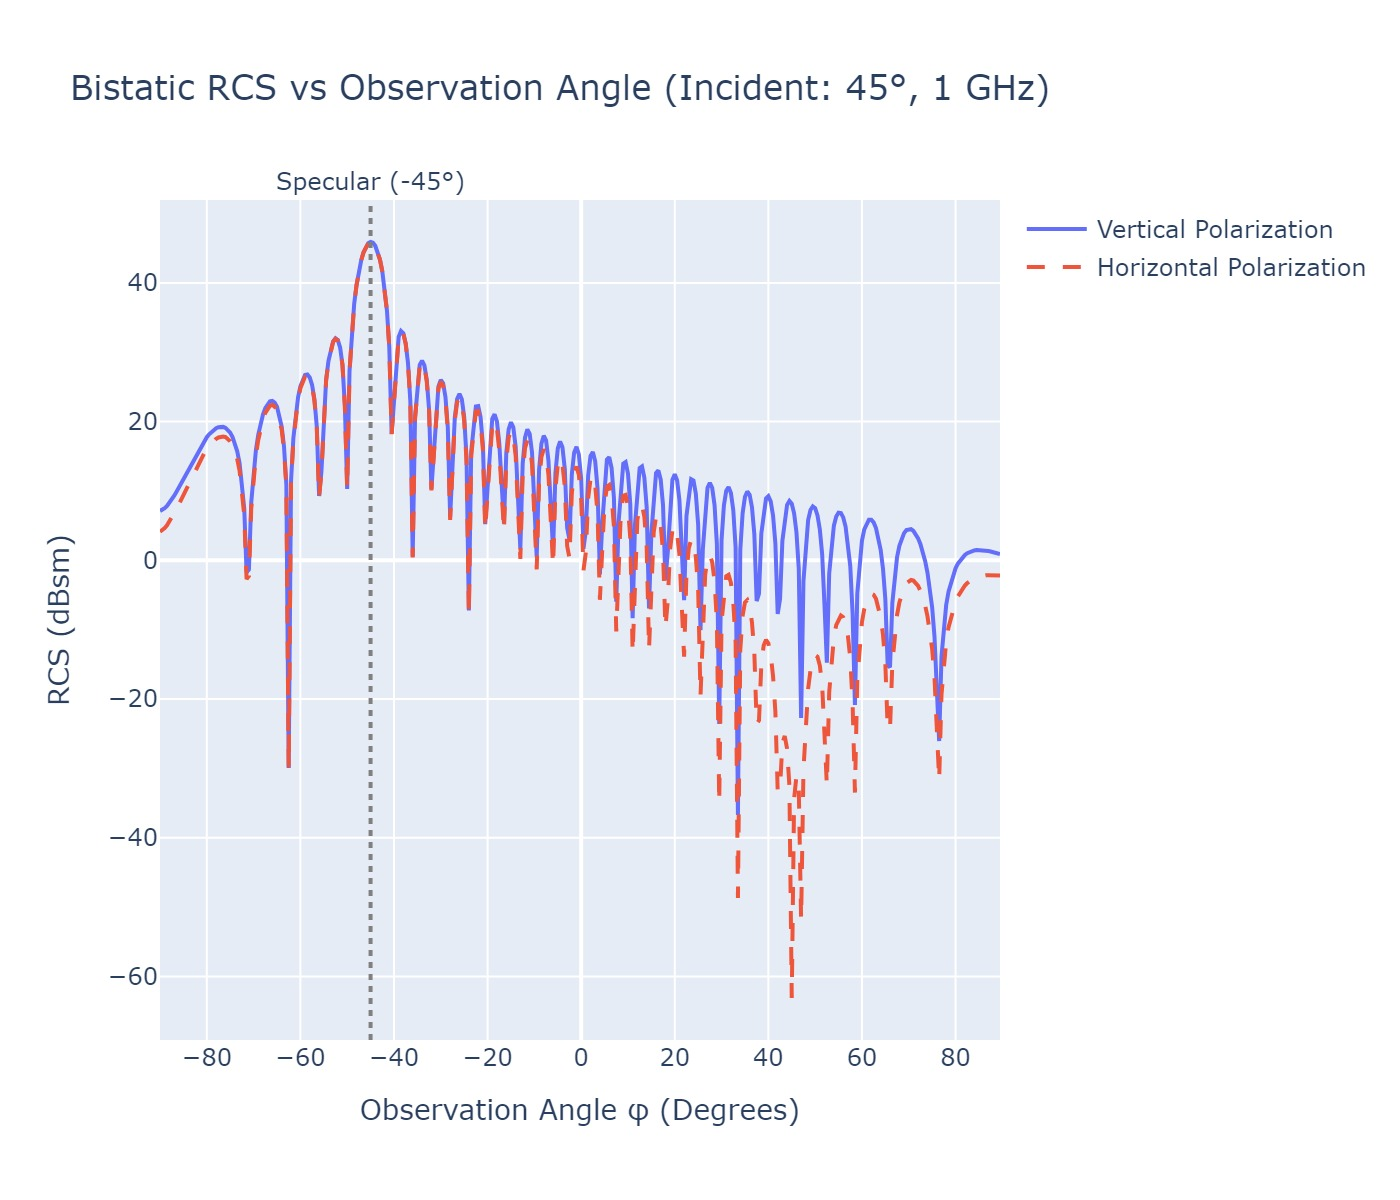

In [8]:
# Create figure for bistatic RCS comparison
fig = go.Figure()

# Plot vertical polarization RCS
fig.add_trace(go.Scatter(
    x=obs_phi,
    y=rcs_vpol,
    mode='lines',
    name="Vertical Polarization",
    line=dict(width=2)
))

# Plot horizontal polarization RCS
fig.add_trace(go.Scatter(
    x=obs_phi,
    y=rcs_hpol,
    mode='lines',
    name="Horizontal Polarization",
    line=dict(width=2, dash='dash')
))

# Add vertical line at specular angle (-45°)
fig.add_vline(
    x=-45,
    line_dash="dot",
    line_color="gray",
    annotation_text="Specular (-45°)",
    annotation_position="top"
)

# Configure plot layout
fig.update_layout(
    title="Bistatic RCS vs Observation Angle (Incident: 45°, 1 GHz)",
    yaxis=dict(title="RCS (dBsm)"),
    xaxis=dict(title="Observation Angle φ (Degrees)", dtick=20),
    height=600,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

In this notebook, you learned how to simulate and analyze the Radar Cross Section of a flat plate using RadarSimPy:

### Key Takeaways

**1. Flat Plate Fundamentals**
- Understood flat plates as canonical scatterers with analytical solutions
- Learned theoretical RCS formula: σ = 4πL²/λ² for normal incidence
- Explored specular reflection as the dominant scattering mechanism
- Recognized flat plates as building blocks for complex target modeling

**2. Monostatic RCS Analysis**
- Simulated co-located transmitter/receiver configuration
- Compared Perfect Electric Conductor (PEC) vs. glass (εᵣ = 5) materials
- Observed 10-15 dB RCS reduction for dielectric vs. conductor
- Analyzed narrow main lobe (~3-4°) due to large electrical size (17λ)

**3. Material Property Effects**
- PEC represents ideal metal with 100% reflection
- Dielectric materials show partial reflection based on permittivity
- Glass plate demonstrates reduced RCS compared to metal
- Fresnel reflection coefficients govern dielectric scattering

**4. Bistatic RCS Analysis**
- Configured separate incident and observation angles
- Located specular peak at mirror reflection angle (-45° for 45° incidence)
- Observed polarization-dependent scattering (V-pol vs. H-pol)
- Analyzed asymmetric patterns characteristic of bistatic geometry

**5. Polarization Effects**
- Vertical and horizontal polarizations scatter differently
- Polarization dependence increases at oblique angles
- Reflection coefficients depend on both angle and polarization
- Useful for target discrimination and identification

**6. Simulation Techniques**
- Used efficient vectorized computation for monostatic (single sim_rcs call)
- Applied loop-based approach for bistatic (different inc/obs angles)
- Balanced ray density (4 vs. 1) for accuracy vs. speed
- Added small constants to avoid numerical issues with deep nulls

### Experiment Further

Try modifying the parameters to explore different scenarios:

1. **Theoretical Validation**:
   - Calculate theoretical RCS: σ = 4π(5²)²/(0.3²) = 34,907 m² ≈ 45.4 dBsm
   - Compare with simulated peak at 0° in monostatic case
   - Validate sinc² angular dependence

2. **Frequency Sweep**:
   - Test different frequencies: 300 MHz, 3 GHz, 10 GHz, 30 GHz
   - Observe how pattern sharpens with frequency (electrical size increases)
   - Plot RCS vs. frequency to verify λ⁻² dependence

3. **Plate Size Variations**:
   - Try smaller plates (1m × 1m, 2m × 2m)
   - Observe beamwidth increase for smaller plates
   - Compare with theoretical beamwidth predictions

4. **Material Studies**:
   - Test different permittivity values: εᵣ = 2, 4, 10, 20
   - Add loss tangent: complex permittivity ε = ε' - jε''
   - Compare radar-absorbing materials (RAM) vs. conductors

5. **Bistatic Angle Variations**:
   - Change incident angle: 30°, 60°, 75°
   - Verify specular peak shifts to mirror angle
   - Create bistatic angle plots (incident vs. observation)

6. **Polarization Analysis**:
   - Test cross-polarization (H-incident, V-observation)
   - Compute co-pol vs. cross-pol ratios
   - Analyze polarization scattering matrices

7. **3D Pattern Visualization**:
   - Vary both azimuth (φ) and elevation (θ)
   - Create 3D RCS patterns or 2D heatmaps
   - Generate polar plots for intuitive visualization

8. **Aspect Angle Studies**:
   - Rotate the plate to different orientations
   - Observe RCS vs. pitch, roll, yaw angles
   - Simulate tumbling or rotating targets

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Simulator Module: https://radarsimx.github.io/radarsimpy/simulator.html
- PyMeshLab Documentation: https://pymeshlab.readthedocs.io/
- Flat Plate RCS Theory: Classical electromagnetic scattering solutions
- Physical Optics: High-frequency approximation methods
- Fresnel Equations: Reflection and transmission at dielectric interfaces
- Bistatic Radar: Multi-static radar systems and applications
- Polarimetric Radar: Polarization diversity in radar systems